In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
# Load Dataset and Labels

data = pd.read_csv("../data/dataset.csv") 
labels = pd.read_csv("../data/label.csv")['Label'] # to be used for evalutaion purposes

#print("Anomalous Traffic Count:",list(labels).count(1))
#print("Normal Traffic Count:",list(labels).count(0))

In [3]:
# Training on Only Normal Data and Testing on a Mix of Normal and Anomalous Data

full_data = data.copy()
full_data['Label'] = labels

normal_data = full_data[full_data['Label']==0]
normal_labels = normal_data["Label"]
normal_data = normal_data.drop(labels=["Label"], axis=1)

x_train, X_test, y_train, Y_test = train_test_split(normal_data, normal_labels, test_size=0.3, random_state=42)  

anomalies = full_data[full_data['Label']==1]

samples = [38, 80, 309]  # Anomaly Rate is 5%, 10%, 30% 

anomalous_data = list(map(lambda x: anomalies.sample(n=x, random_state=42), samples))
anomalous_label = list(map(lambda x: x["Label"], anomalous_data))
anomalous_data = list(map(lambda x: x.drop(labels=["Label"], axis=1), anomalous_data))

x_tests = list(map(lambda x: pd.concat([X_test, x], axis=0), anomalous_data))
y_tests = list(map(lambda x: pd.concat([Y_test, x], axis=0), anomalous_label))
shuffled = list(map(lambda x,y: shuffle(x,y, random_state=42), x_tests, y_tests))
x_tests = list(map(lambda x: x[0], shuffled))
true_labels = list(map(lambda x: x[1], shuffled))

# Normalizing the Data
scaler = Normalizer()

x_train_scaled = scaler.fit_transform(x_train)
test_scaled = list(map(lambda x: scaler.fit_transform(x), x_tests))

# Covert to Tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
test_tensors = list(map(lambda x: torch.tensor(x, dtype=torch.float32), test_scaled))


In [4]:
class Autoencoder(nn.Module):
    '''
    Autoencoder Model
    '''
    def __init__(self, input_dim, encoding_dim, dropout) -> None:
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),     
            nn.ReLU(),                              
            nn.Dropout(dropout),
            nn.Linear(input_dim // 2, encoding_dim),     
            nn.ReLU(),  
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 2, ),    
            nn.ReLU(),  
            nn.Dropout(dropout),
            nn.Linear(input_dim //2, input_dim),  
            nn.ReLU(),
        )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Hyperparameters                               
INPUT_DIM = x_train_tensor.shape[1]
ENCODING_DIM = 5
DROPOUT = 0.01
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0003

model = Autoencoder(input_dim=INPUT_DIM,encoding_dim=ENCODING_DIM, dropout=DROPOUT)
print(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)  
loss_function = nn.MSELoss()

train_dataloader = DataLoader(x_train_tensor, batch_size=BATCH_SIZE, shuffle=True)

# Initializing Lists for Average MSE on Each Epoch
train_losses = [] 
test_losses = [[], [], []] # [[5% anomalies], [10% anomalies], [30% anomalies]]

# Initializing Lists for Reconstucted Matrix on Each Epoch
reconstructed_train = []
reconstructed_test = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = []
    print(f"[TRAINING]: Starting epoch {epoch}...")
    for batch in train_dataloader:
        reconstructed = model(batch)
        reconstructed_train.append(reconstructed)
        loss = loss_function(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    
    loss_train = torch.tensor(epoch_loss).mean().item()
    train_losses.append(loss_train)

    # Evaluating Model on Test Set
    model.eval()
    with torch.no_grad():
        for i in range(3):
            x_test_tensor = test_tensors[i]
            test_output = model(x_test_tensor)
            reconstruction_error = np.mean(np.power(x_test_tensor.detach().numpy() - test_output.detach().numpy(), 2), axis=1)

            loss_test = loss_function(test_output, x_test_tensor).item()
            test_losses[i].append(loss_test)
    
    print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {loss_train}")


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=89, out_features=44, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=44, out_features=5, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.01, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=44, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.01, inplace=False)
    (3): Linear(in_features=44, out_features=89, bias=True)
    (4): ReLU()
  )
)
[TRAINING]: Starting epoch 0...
Epoch 1/100, Training Loss: 0.009791894815862179
[TRAINING]: Starting epoch 1...
Epoch 2/100, Training Loss: 0.007665538694709539
[TRAINING]: Starting epoch 2...
Epoch 3/100, Training Loss: 0.005622894503176212
[TRAINING]: Starting epoch 3...
Epoch 4/100, Training Loss: 0.004482518415898085
[TRAINING]: Starting epoch 4...
Epoch 5/100, Training Loss: 0.004359877668321133
[TRAINING]: Starting epoch 5...
Epoch 6/100, Training Loss: 0.0042900629341602325
[TRAINING]: Starti

In [6]:
# Calculating Reconstruction Error for Each Anomaly Rate
reconstructed = []
model.eval()
with torch.no_grad():
    for i in range(3):
        x_test_tensor = test_tensors[i]
        reconstructed_test = model(x_test_tensor).detach().numpy()
        reconstructed.append(reconstructed_test)

# Reconstruction Errors
test_error = list(map(lambda x,y: np.mean((x.detach().numpy() - y) ** 2, axis=1), test_tensors, reconstructed))

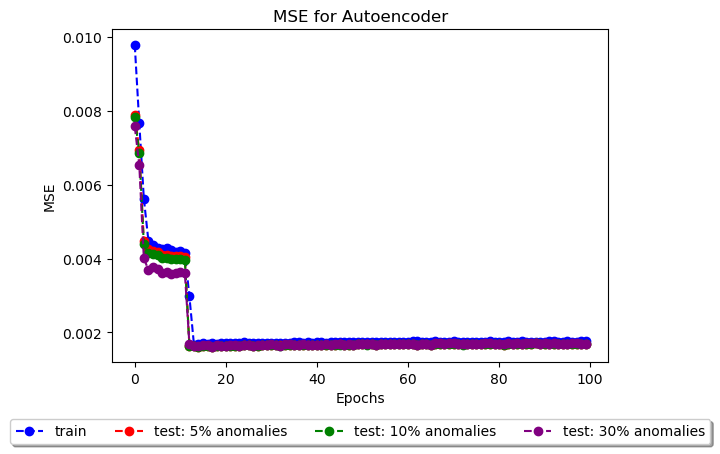

In [7]:
# Plotting Test and Train MSE for Each Anomaly Rate

epochs = list(range(EPOCHS))

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(epochs, train_losses, '--o', color="blue", label="train")
ax.plot(epochs, test_losses[0], '--o', color="red", label="test: 5% anomalies")
ax.plot(epochs, test_losses[1], '--o', color="green", label="test: 10% anomalies")
ax.plot(epochs, test_losses[2], '--o', color="purple", label="test: 30% anomalies")

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

ax.set_title('MSE for Autoencoder')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
plt.show()

In [8]:
# K-Means Clustering on the Test Set (ONLY ON THE RECONSTRUCTION ERRORS)

kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42) 

predictions = list(map(lambda x: kmeans.fit_predict(x.reshape(-1,1)), test_error))
anomaly_label = []
for i in predictions:
    cluster1 = len(i[i==1])
    cluster2 = len(i[i==0])
    if cluster1 >= cluster2:         # Anomalous cluster is the smaller cluster
        anomaly_label.append(0)
    else:
        anomaly_label.append(1)

# Relabels predictions so that the smaller cluster is anomalous (1) and the larger cluster is normal (0)
predicted_labels = list(map(lambda x,y: np.where(x==y, 1, 0), predictions, anomaly_label))  

classification_reports = list(map(lambda x,y: classification_report(x,y), true_labels, predicted_labels))
confusion_matrices = list(map(lambda x,y: confusion_matrix(x,y), true_labels, predicted_labels))

for x,y,z in zip(classification_reports, confusion_matrices, ["5%", "10%", "30%"]):
    print(f'Classification Report for {z} anomalies:')
    print(x)
    print(f'Confusion Matrix for {z} anomalies:')
    print(y)



Classification Report for 5% anomalies:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       719
           1       0.03      0.08      0.05        38

    accuracy                           0.84       757
   macro avg       0.49      0.48      0.48       757
weighted avg       0.90      0.84      0.87       757

Confusion Matrix for 5% anomalies:
[[635  84]
 [ 35   3]]
Classification Report for 10% anomalies:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       719
           1       0.04      0.12      0.06        80

    accuracy                           0.60       799
   macro avg       0.45      0.39      0.40       799
weighted avg       0.79      0.60      0.67       799

Confusion Matrix for 10% anomalies:
[[466 253]
 [ 70  10]]
Classification Report for 30% anomalies:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       71

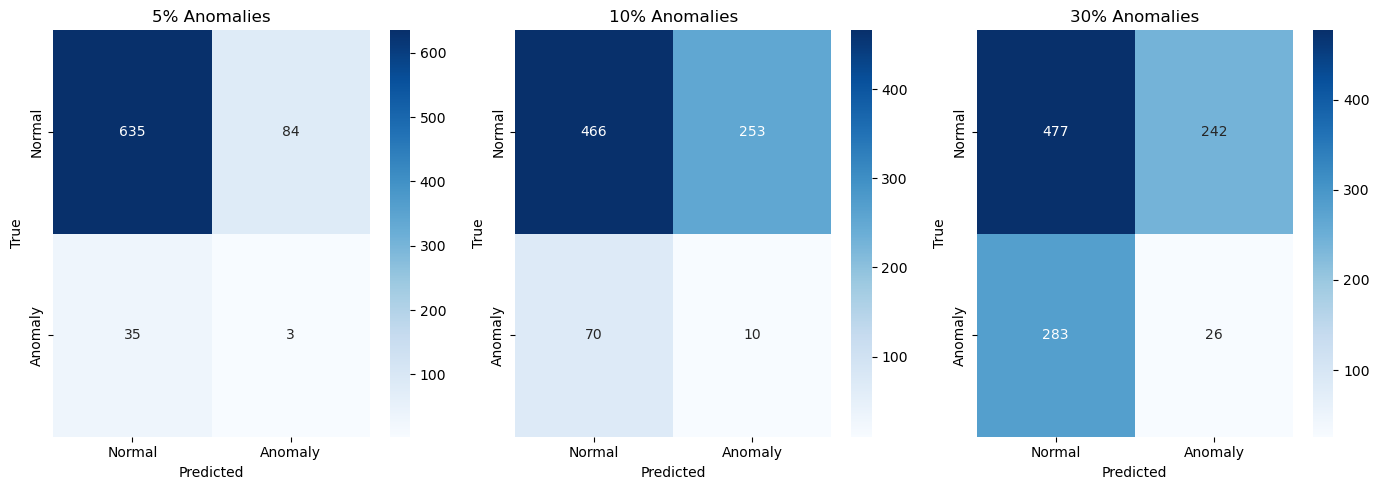

In [9]:
# Plotting Confusion Matricies for Each Anomaly Rate

titles = ["5% Anomalies", "10% Anomalies", "30% Anomalies"]

fig, axs = plt.subplots(1, 3, figsize=(14,5))

for i in range(3):
    sns.heatmap(ax=axs[i], data=confusion_matrices[i], annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("True")

fig.tight_layout()
plt.show()